# ML Project phase 2 - OneByOne
---


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# !pip install contractions
# import contractions
import re
import nltk
import tensorflow as tf
# !pip install gensim
import gensim
from nltk.corpus import stopwords

In [2]:
%config Completer.use_jedi = False

df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')
np.random.seed(0)
train_ratio = 808998/len(df)
msk = np.random.rand(len(df)) <= train_ratio

data = df[msk].copy()
test = df[~msk].copy()

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('drive/MyDrive/Temp/sarcasm_train_set.csv')

# !cp '../content/drive/MyDrive/Kaggle/projectPhase2_dataset.zip' '/content'
# !unzip -q 'projectPhase2_dataset.zip'
# # data = pd.read_csv('drive/MyDrive/drive/MyDrive/sarcasm_train_set.csv')
# data = pd.read_csv('sarcasm_train_set.csv')

In [4]:
data.dropna(subset=['comment'], inplace=True)
data.isna().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [5]:
# from nltk.corpus import stopwords
# nltk.download('wordnet')
# nltk.download('stopwords')

# def preprocess(data, remove_stop_words=False, remove_special=False):
#     pre_data = data.apply(lambda x : contractions.fix(x))
#     if remove_special:
#         pre_data = pre_data.apply(lambda x: re.sub('[^a-zA-Z0-9]+', ' ', x))

#     lemmatizer = nltk.stem.WordNetLemmatizer()
#     for pos_tag in ['v', 'n', 'a']: # v for verbs, n for nouns and a for adverbs
#         pre_data = pre_data.apply(lambda text: ' '.join([lemmatizer.lemmatize(w, pos_tag) for w in text.split()]) )

#     if remove_stop_words:
#         stop_words = set(stopwords.words('english'))
#         pre_data = pre_data.apply(lambda text: ' '.join(word for word in text.split() if not word.lower() in stop_words))
#     return pre_data

s = pd.Series([' '] * len(data))
data.comment = data.subreddit + s + data.comment

In [9]:
data.dropna(subset=['comment'], inplace=True)
data.comment

0                                       politics NC and NH.
1         nba You do know west teams play against west t...
2         nfl They were underdogs earlier today, but sin...
3         BlackPeopleTwitter This meme isn't funny none ...
4         MaddenUltimateTeam I could use one of those to...
                                ...                        
808394         ultrahardcore Screw you guys for having fun!
808395                         RedditLaqueristas Thank you!
808396    WTF Reddit is filled with ugly *guys*, nobody ...
808398                             nba Inb4 Bulls get swept
808399    pics Hmm I wonder if that has been done before...
Name: comment, Length: 646736, dtype: object

In [10]:
def replace_zero_length(pre_data):
    k = np.where(pre_data.apply(lambda x: len(x) == 0))[0]
    print(len(k))
    pre_data.iloc[k] = 'None'
    return pre_data


raw_data = data['comment']
# pre_data = replace_zero_length(preprocess(data['comment']))

# pre_sentences = [[word for word in document.lower().split()] for document in pre_data]
raw_sentences = [[word for word in document.lower().split()] for document in raw_data]

In [11]:
test.dropna(subset=['comment'], inplace=True)
s = pd.Series([' '] * len(test))
test.comment = test.subreddit + s + test.comment
test.dropna(subset=['comment'], inplace=True)
raw_test = test.comment
raw_test_sentences = [[word for word in document.lower().split()] for document in raw_test]

In [12]:
test.comment.tail(10)

202335    Drugs Well, with this new bill, isn't it that ...
202338    streetwear People that leave their home town f...
202340    leagueoflegends Yea screw you for wanting to w...
202342    The_Donald Surely once they have a larger popu...
202344                            politics Big League* FTFY
202349                           Pmsforsale Trade verified!
202350                        Atlanta The Local is my go to
202362    CringeAnarchy Oh shit he stole his fathers sho...
202364    hockey "Ask you what you know, bout them hocke...
202372    electricdaisycarnival That walgreens/cvs is th...
Name: comment, dtype: object

## Embedding 


* **Word2Vec**

In [13]:
# pre_embed = gensim.models.Word2Vec(pre_sentences, vector_size=100, window=5, min_count=1)
raw_embed = gensim.models.Word2Vec(raw_sentences, vector_size=100, window=5, min_count=1)

In [27]:
def get_word2vec_enc(comments, embed):
    encoded_comments = []
    for comment in comments:
        try:
            word2vec_embedding = embed.wv[comment]
            encoded_comments.append(word2vec_embedding)
        except KeyError:
            encoded_comments.append(np.zeros(100).reshape(1, 100))
    return encoded_comments
        
def word2vec_padding(df, embed):    
    encoded_comment = get_word2vec_enc(df,embed)
    padded_encoded_comments = tf.keras.preprocessing.sequence.pad_sequences(encoded_comment, maxlen=100, dtype="float64", padding='post')
    X = np.array(padded_encoded_comments)
    return X

In [28]:
# w2v_pre_x = word2vec_padding(pre_sentences[0:10000], pre_embed)
# w2v_raw_x = word2vec_padding(raw_sentences[0:10000], raw_embed)

* **TF-IDF:**

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)
raw_x_itf = vectorizer.fit_transform(raw_data)

# vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100000, min_df=2)
# pre_x_itf = vectorizer.fit_transform(pre_data)

KeyboardInterrupt: 

---

* **Custom deep neural network:**

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot as plt
import sys
!pip install colorama
import colorama
from collections import OrderedDict
from matplotlib import pyplot as plt 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
torch.set_printoptions(precision=3)
import os
import sklearn.metrics as met


In [18]:
import gc
gc.collect()
y=data['label']
# dset = []
# for i, mat in enumerate(w2v_raw_x):
#     t = torch.from_numpy(mat)
#     dset.append((t, y[i]))

In [30]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, embed, sentences, labels):
        self.embed = embed
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        vec = word2vec_padding([self.sentences[idx]], self.embed)[0]
        return torch.from_numpy(vec).unsqueeze(0), self.labels.iloc[idx]


train_data = CustomDataset(raw_embed, raw_sentences, y)
test_data = CustomDataset(raw_embed, raw_test_sentences, test.label)

In [31]:
from torch.utils.data import DataLoader

def self_sampler(dataset):
    return SubsetRandomSampler(np.random.choice(np.array(list(range(len(dataset)))),\
                                                    size=len(dataset), replace=False))

def loader(dataset, sampler=None):
    samp = None
    if sampler is not None:
        samp = sampler
    else:
        samp = self_sampler(dataset)
    return DataLoader(dataset, 
                      batch_size = batch_size,
                      sampler = samp,
                      num_workers = num_workers)

val_size = 0.15
num_workers = 4
batch_size = 512

# creating train and validation data samples:
num = len(train_data)
sp = int(val_size * num)
ind = list(range(num))
np.random.shuffle(ind)
val_ind, train_ind = ind[:sp], ind[sp:]
train_samp, val_samp = SubsetRandomSampler(train_ind), SubsetRandomSampler(val_ind)

train_loader = loader(train_data, train_samp)
val_loader = loader(train_data, val_samp)
test_loader = loader(test_data)

In [32]:
next(iter(test_loader))[0].shape

torch.Size([512, 1, 100, 100])

In [33]:
class N_net(nn.Module):
    def __init__(self):
        super(N_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 100), stride=1)
        self.convAug = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, 100), stride=1)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.bnorm = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 1), stride=2)        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 1), stride=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 1), stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 1), stride=1)
        self.fc = nn.Linear(in_features=672, out_features=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(2, 1), stride=1)
        self.fc2 = nn.Linear(in_features=704, out_features=2)

    def forward(self, x):
#         out = x.view(x.shape[0], -1)
        out = self.conv1(x)
        in2 = self.convAug(x)
        out = self.bnorm(out)
        in2 = self.bnorm(in2)
        out = F.relu(out)
        in2 = F.relu(out)
        out = self.pool1(out)
        in2 = self.pool1(in2)
        out = self.conv2(out)
        in2 = self.conv2(in2)
        out = self.bnorm(out)
        in2 = self.bnorm(in2)
        out = F.relu(out)
        in2 = F.relu(in2)
        out = self.pool2(out)
        in2 = self.pool2(in2)
        out = self.conv3(out)
        in2 = self.conv4(in2)
        out = out.view(out.shape[0], -1)
        in2 = in2.view(in2.shape[0], -1)
        out = self.fc(out)
        in2 = self.fc2(in2)
        out = F.softmax(out + in2)
        return out

In [ ]:
nn_model = N_net()

In [ ]:
test_input = torch.randn(512, 1, 100, 100) 
out = nn_model(test_input)
print("out.shape: \n%s" % (out.shape,))

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import gc
test_acc_all, train_acc_all, val_acc_all, train_loss_all = [], [], [], []
acc_all, f1_all, prec_all, rec_all = [], [], [], []

def train_cnn(model, train_loader, test_loader, val_loader, device, num_epochs, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.2, patience=3, verbose=True)
    blocks, best_acc = 0, 0
    for epoch in range(num_epochs):
        print("=" * 25, "Starting epoch %d" % (epoch + 1), "=" * 25)
        names = ['train_loader']
        for d_idx, dataloader in enumerate([train_loader]):
            for batch_idx, (data, labels) in enumerate(dataloader):
                if batch_idx % 5 == 0:
                    gc.collect()
                model.train()
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output[:, 1].to(torch.float64), labels.to(torch.float64))
                loss.backward()
                optimizer.step()
                if batch_idx % 500 == 0 and batch_idx != 0:
                    print("\nstarting batch %d/%d, Loss=%.4f" % (batch_idx, len(dataloader), loss.item()))
#                     print('on: ', names[d_idx])
                    train_acc = accuracy(model, train_loader, device)
#                     val_acc = accuracy(model, val_loader, device)
#                     test_acc = accuracy(model, test_loader, device)
                    val_acc, f1, prec, rec = score(model, val_loader, device)
                    acc_all.append(val_acc); f1_all.append(f1); prec_all.append(prec); rec_all.append(rec);
                    train_acc_all.append(train_acc); val_acc_all.append(val_acc); train_loss_all.append(loss.item());
                    gc.collect()
                    if val_acc > best_acc:
                        torch.save(model.state_dict(), 'model.pt')
                        best_acc = val_acc
                    print(colorama.Fore.GREEN, "Accuracy on training: %.2f%%" % (100*train_acc))
                    print("Accuracy on val: %.2f%%" % (100*val_acc))                
#                     print("Accuracy on test: %.2f%%" % (100*test_acc), colorama.Fore.RESET) 
#                     print(f'F1 score on test : {100*f1:.2f}')
#                     print(f'Precision score on test : {100*prec:.2f}')
#                     print(f'Recall score on test : {100*rec:.2f}', colorama.Fore.RESET)
#                     test_acc_all.append(test_acc); 

                    blocks += 1
                    plot_train(val_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks)
                    plot_scores(acc_all, f1_all, prec_all, rec_all, epoch=blocks)
                    scheduler.step(val_acc)
                    

In [42]:
def accuracy(model, dataloader, device):
    model.eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            predictions = model(data).max(1)[1]
            num_correct += (predictions == labels).sum().item()
            num_samples += predictions.shape[0]
    return num_correct / num_samples

def print_score(y_test, pred):
    print('Accuracy:  ', met.accuracy_score(y_test, pred))
    print('F1_score:  ', met.f1_score(y_test, pred))
    print('Precision: ', met.precision_score(y_test, pred))
    print('Recall:    ', met.recall_score(y_test, pred))
    
def score(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    print_score(y_test, pred)
    return met.accuracy_score(y_test, pred), met.f1_score(y_test, pred),\
    met.precision_score(y_test, pred),\
    met.recall_score(y_test, pred)

def plot_conmat(model, dataloader, device):
    model.eval()
    pred, y_test = [], []
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            pred += list(model(data).max(1)[1].cpu().numpy())
            y_test += list(labels.cpu().numpy())
    c = met.confusion_matrix(y_test, pred)
    disp = met.ConfusionMatrixDisplay(c)
    plt.figure(figsize=(10, 6))
    disp.plot()

In [43]:
def plot_train(test_acc_all, train_acc_all, val_acc_all, train_loss_all, blocks):
    plt.figure(figsize=(10, 6))
    x = np.arange(blocks)
    plt.plot(x, train_acc_all, label='train accuracy');
    plt.plot(x, val_acc_all, label='validation accuracy');
#     plt.plot(x, test_acc_all, label='test accuracy');
#     plt.plot(reg, mean_f1, label='F1_score');
    plt.xlabel('500-Batch training blocks');
    plt.ylabel('Model accuracy');
    plt.title('Model prediction accuracy by training batches');
    plt.legend();
    plt.show();
    
def plot_scores(acc_all, f1_all, prec_all, rec_all, epoch):
    plt.figure(figsize=(10, 6))
    x = np.arange(epoch)
    plt.plot(x, acc_all, label='val accuracy');
    plt.plot(x, f1_all, label='val F1 score');
    plt.plot(x, prec_all, label='val precision');
    plt.plot(x, rec_all, label='val recall');
    plt.xlabel('Number of 500-Batch training blocks');
    plt.ylabel('Model scores');
    plt.title('Model prediction scores on validation data by training epochs');
    plt.legend();
    plt.show();

In [ ]:
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu')
nn_model = nn_model.to(device)

train_cnn(nn_model.double(), train_loader, val_loader, val_loader, device, num_epochs=200, lr=0.003)

In [35]:
nn_model = N_net()
print(nn_model)

N_net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 100), stride=(1, 1))
  (convAug): Conv2d(1, 32, kernel_size=(1, 100), stride=(1, 1))
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1))
  (fc): Linear(in_features=672, out_features=2, bias=True)
  (conv4): Conv2d(32, 32, kernel_size=(2, 1), stride=(1, 1))
  (fc2): Linear(in_features=704, out_features=2, bias=True)
)


In [40]:
cn = nn_model
cn.load_state_dict(torch.load('../input/modelpt/model.pt'))

<All keys matched successfully>

In [45]:
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu')
cn = cn.to(device)
val_acc, f1, prec, rec = score(cn.double(), val_loader, device)

Accuracy:   0.6232656427172456
F1_score:   0.6810990986274356
Precision:  0.5809553580732074
Recall:     0.8229588394062078


In [46]:
val_acc, f1, prec, rec = score(cn.double(), test_loader, device)

Accuracy:   0.61744801279685
F1_score:   0.5991387090951288
Precision:  0.5493970205722393
Recall:     0.6587841669502098


<Figure size 720x432 with 0 Axes>

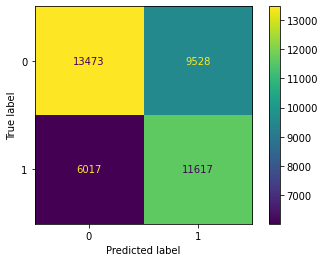

In [48]:
plot_conmat(cn.double(), test_loader, device)